In [1]:
import numpy as np
import random, math, copy, gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
env = gym.make('MountainCar-v0')

In [3]:
class Qagent(torch.nn.Module):
    
    def __init__(self, env):
        super(Qagent, self).__init__()
        
        self.env = env
        self.input_dim = self.env.observation_space.shape[0]
        self.output_dim = self.env.action_space.n
        self.fc1 = nn.Linear(self.input_dim, 240)
        self.fc2 = nn.Linear(240, 240)
        self.fc3 = nn.Linear(240, self.output_dim)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
        
    def action(self, state, epsilon=0):
        qvalues = self.forward(torch.from_numpy(state).float())
        coin = random.random()
        # epsilon-greedy action 선택
        if coin < epsilon:
            a = random.randint(0,self.output_dim-1)
        else : 
            a = qvalues.argmax().item() 
    
        return a 
    
    def test(self, test_num, render_op=False):
        
        reward_history =[]
        
        for i in range(test_num):
            s = self.env.reset()
            d = False
            epi_r = 0
            
            while not d:
                
                if render_op:
                    self.env.render()
                a = self.action(s, epsilon=0) #greedy action     
                s, r, d, info = self.env.step(a)
                epi_r += r
            
            reward_history.append(epi_r)
            if render_op:
                print("{}-번째 테스크 결과는 {}".format(i+1, epi_r))
            
        self.env.close()
        if render_op:
            print("{}-번 게임의 평균 점수는 {}, 최고점수는 {}".format(test_num, np.mean(reward_history),np.max(reward_history)))
        else:
            return np.mean(reward_history)
        
        
    
    
    def save_models(self, name=None):
        if name == None:
            name = 'noname'
        torch.save(self.state_dict(), name + '_qnet.pt')
        print('Models saved successfully')
    
    def load_models(self, name=None):
        if name ==None:
            name = 'noname'
        self.load_state_dict(torch.load(name + '_qnet.pt'))
        print ('Models loaded succesfully')
    



In [4]:
# hyper parameters
class hp:   #collection of hyper parameters
    def __init__(self):
        
        self.save_file_name = 'mountain_car_dqn' #여러분이 원하는 이름 
        
        self.lr = 3e-4
        self.gamma = 0.99
        self.num_training = int(5e4) 
        self.buffersize = int(2e3)  
        self.minibatchsize = 24 
        self.start_from = int(1e2) 
        self.print_interval = int(2e3)
        self.target_update_interval = int(1e3) 
        self.init_ep = 1
        self.min_ep = 0.01
        self.decay = int(1e3) 

In [5]:
class ReplayBuffer:
    
    def __init__(self, buffer_limit, mini_size):
        
        self.buffer = deque(maxlen=buffer_limit)
        self.batch_size = mini_size
    
    
    def put(self, sarsd):
        self.buffer.append(sarsd)
    
    def sample(self):
        mini_batch = random.sample(self.buffer, self.batch_size)
        s_list, a_list, r_list, s_prime_list, done_list = [], [], [], [], []
        
        for sarsd in mini_batch:
            s, a, r, s_prime, done = sarsd
            s_list.append(s)
            a_list.append([a])
            r_list.append([r])
            s_prime_list.append(s_prime)
            done_list.append([done])

        return torch.FloatTensor(s_list), torch.tensor(a_list), torch.FloatTensor(r_list),\
                torch.FloatTensor(s_prime_list), torch.FloatTensor(done_list)
    
    def size(self):
        return len(self.buffer)

In [6]:
class DQN:

    def __init__(self, agent, env, hps):
        
        self.agent = agent
        self.env   = env
        self.targetA = copy.deepcopy(self.agent)
        self.targetupdate()
        self.hps     = hps
        
        self.lrate = self.hps.lr
        self.gamma = self.hps.gamma
        self.ram =  ReplayBuffer(self.hps.buffersize, self.hps.minibatchsize)
        self.target_update_interval = self.hps.target_update_interval
        
        self.update_ctr = 0
        self.training_ctr = 0
        
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.lrate)
        
    
    def targetupdate(self):
        return self.targetA.load_state_dict(self.agent.state_dict())
    
    def plot(self, frame_idx, rewards, test_score, losses):
        clear_output(True)
        plt.figure(figsize=(12,6))
        plt.subplot(131)
        plt.title('Frame %s k. last 10 epi reward mean: %.2f' % (int(frame_idx/1000), np.mean(rewards[-10:])))
        plt.plot(rewards, 'k-')
        plt.subplot(132)
        plt.title('Test Score')
        plt.plot(test_score, 'r--')
        plt.subplot(133)
        plt.title('Loss')
        plt.plot(losses)
        plt.savefig(str(self.hps.save_file_name)+'.png')
        plt.show()
    
    
    def train(self):
            
        s,a,r,s_prime,done = self.ram.sample()
        qvalues = self.agent(s)
        q_a = qvalues.gather(1,a)
        with torch.no_grad():
            max_q_sprime = self.targetA(s_prime).max(1)[0].unsqueeze(1)
        target = r + self.gamma * max_q_sprime * done
        loss = F.mse_loss(q_a, target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
            
    def learning(self):
        self.reward_history =[]
        self.test_history = []
        self.loss_history =[]
        
        ep = lambda frame_num : self.hps.min_ep + (self.hps.init_ep - self.hps.min_ep) * math.exp(-1. * frame_num / self.hps.decay) 
        
        s = self.env.reset()
        d = False
        epi_r = 0
            
        
        while self.training_ctr < self.hps.num_training:
            epsilon = ep(self.training_ctr)
            a = self.agent.action(s, epsilon)      
            s_prime, r, d, info = self.env.step(a)
            epi_r += r
            done = 0.0 if d else 1.0
            self.ram.put((s,a,r/50.0, s_prime, done))
            if d:
                s = self.env.reset()
                d = False
                self.reward_history.append(epi_r)
                epi_r = 0
            else:
                s = s_prime
            
            
            if self.ram.size()> self.hps.start_from:
                self.update_ctr +=1
                loss = self.train()
                self.loss_history.append(loss)
                
            if (self.update_ctr +1) % self.target_update_interval ==0:
                self.targetupdate()
            
            if (self.training_ctr+1)%self.hps.print_interval==0:
                self.test_history.append(self.agent.test(20))
                if np.max(self.test_history) == self.test_history[-1]:
                    self.agent.save_models(self.hps.save_file_name)
                self.plot(self.training_ctr+1, self.reward_history, self.test_history, self.loss_history)
            self.training_ctr +=1

In [7]:
hps = hp()
agent = Qagent(env)
trainer = DQN(agent, env, hps)

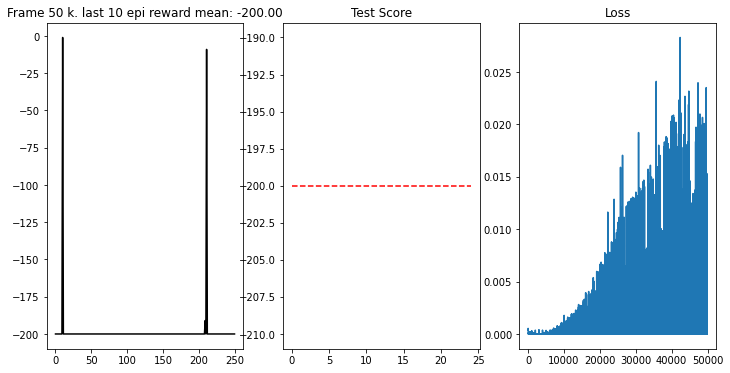

In [8]:
trainer.learning()

In [9]:
agent.load_models('mountain_car_dqn') #여러분이 제출하는 저장 파일 입력
agent.test(20, True)

Models loaded succesfully
1-번째 테스크 결과는 -200.0
2-번째 테스크 결과는 -200.0
3-번째 테스크 결과는 -200.0
4-번째 테스크 결과는 -200.0
5-번째 테스크 결과는 -200.0
6-번째 테스크 결과는 -200.0
7-번째 테스크 결과는 -200.0
8-번째 테스크 결과는 -200.0
9-번째 테스크 결과는 -200.0
10-번째 테스크 결과는 -200.0
11-번째 테스크 결과는 -200.0
12-번째 테스크 결과는 -200.0
13-번째 테스크 결과는 -200.0
14-번째 테스크 결과는 -200.0
15-번째 테스크 결과는 -200.0
16-번째 테스크 결과는 -200.0
17-번째 테스크 결과는 -200.0
18-번째 테스크 결과는 -200.0
19-번째 테스크 결과는 -200.0
20-번째 테스크 결과는 -200.0
20-번 게임의 평균 점수는 -200.0, 최고점수는 -200.0
